In [79]:
from astroquery.vizier import Vizier
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
import lightkurve as lk
import matplotlib.pyplot as plt
from scipy.signal import correlate
import math
%matplotlib inline

In [80]:
def astro_coord(ra_d, dec_d):
    '''
    convert ICRS ra & dec from data to astropy SkyCoord
    '''
    ra_split = ra_d.split(' ')
    dec_split = dec_d.split(' ')
    
    ra_unit = ['h', 'm', 's']
    dec_unit = ['d', 'm', 's']
    
    ra_hms = ''.join([ra_split[idx]+ra_unit[idx] for idx in range(len(ra_split))])
    dec_dms = ''.join([dec_split[idx]+dec_unit[idx] for idx in range(len(dec_split))])
    
    ra = Angle(ra_hms).to(u.deg)
    dec = Angle(dec_dms).to(u.deg)
    
    coord = SkyCoord(ra, dec, frame='icrs')
    
    return coord

def auto_correlation(t, f):
    lt = len(t)

In [81]:
cat = Vizier(catalog='J/AJ/158/77/table2',
            columns=['Source', 'RA_ICRS', 'DE_ICRS', 'GBP-GRP', 'Teff', 'Gmag', 'GMag', 'Prot'])
cat.ROW_LIMIT = -1
data = cat.get_catalogs(cat.catalog)[0].to_pandas()   # downloaded data

In [82]:
data

,Source,RA_ICRS,DE_ICRS,GBP-GRP,Teff,Gmag,GMag,Prot
0,3198972700981234048,04 22 31.5,-07 33 03.2,0.432,7187,8.903,2.802,0.52
1,5181474045115843072,03 10 47.3,-06 34 29.8,0.446,7161,8.562,2.954,0.87
2,2516948215250061568,02 20 22.6,+05 52 59.1,0.597,6622,9.183,3.534,0.82
3,3245408684793798528,04 02 15.4,-05 53 48.2,0.604,6573,9.425,3.513,0.56
4,6628071944405827712,22 36 31.1,-21 35 06.0,0.647,6320,8.967,3.835,0.94
...,...,...,...,...,...,...,...,...
96,5114516020369038848,03 51 15.9,-12 23 46.4,1.732,4298,13.375,7.484,0.68
97,5068272932125221504,02 26 04.6,-29 23 48.9,1.768,4163,12.815,8.000,7.80
98,5094664333632217088,04 02 18.0,-18 42 45.4,1.771,4076,12.631,7.134,2.62
99,5121805541941481472,01 57 17.2,-25 13 49.6,1.784,3956,12.793,7.931,5.45


In [83]:
n_source = len(data)
Coord = []
for i in range(n_source):
    star = data.loc[i]
    source = star['Source']
    
    ra_d = star['RA_ICRS']
    dec_d = star['DE_ICRS']
    
    coord = astro_coord(ra_d, dec_d)
    Coord.append(coord)   # loop through sources and return astropy SkyCoord

In [84]:
sr = lk.search_lightcurve(Coord[0], author="TESS-SPOC")   # check first source on the list

In [85]:
lc_collection = sr.download_all(quality_bitmask='none')   # download lightcurve

In [86]:
lc_collection

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 37860207" SECTOR=5 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 37860207" SECTOR=32 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

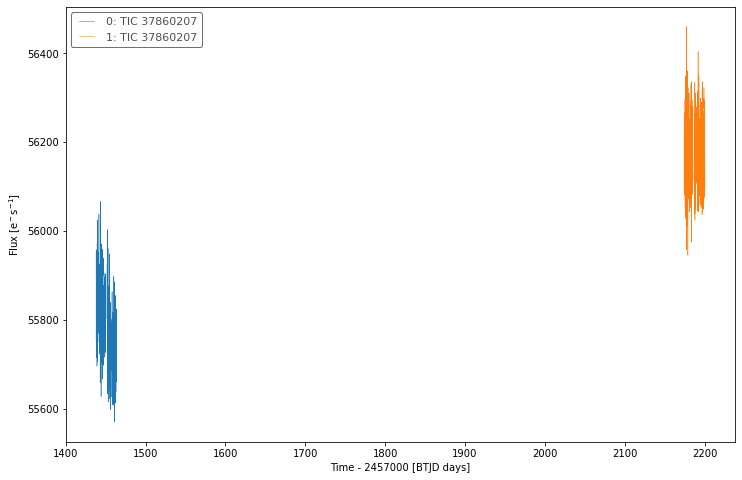

In [87]:
fig, ax = plt.subplots(figsize=(12,8))
lc_collection.plot(ax=ax)   # plot two available lightcurves from source 1

In [88]:
lc_1 = lc_collection[0]
lc_2 = lc_collection[1]   # separate two lightcurves

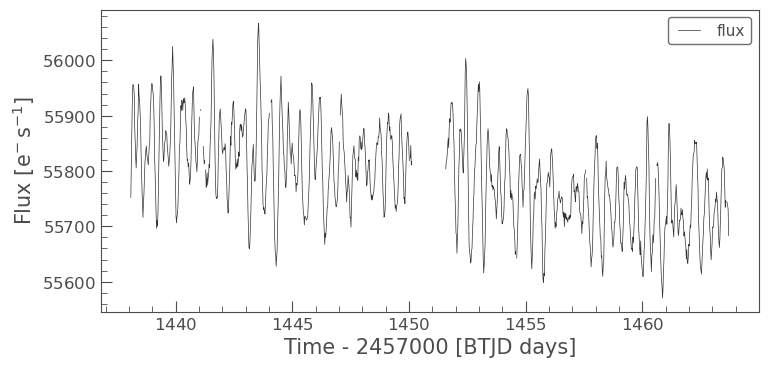

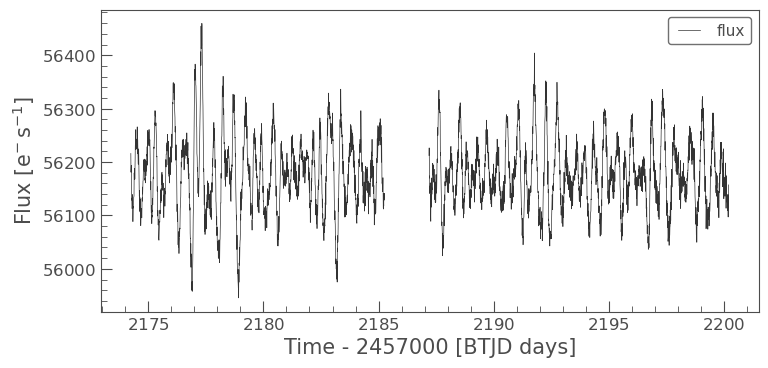

In [89]:
ax1 = lc_1.plot(column='flux', label='flux')
ax2 = lc_2.plot(column='flux', label='flux')   # plot lightcurves individually

(0.0, 6.0)

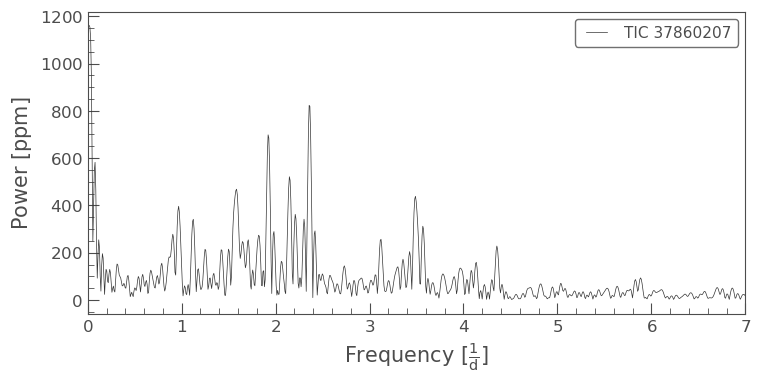

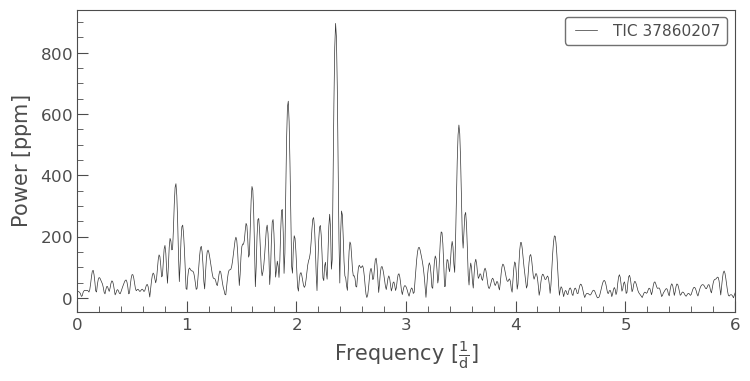

In [90]:
pg1 = lc_1.normalize(unit='ppm').to_periodogram()
pg2 = lc_2.normalize(unit='ppm').to_periodogram()   # obtain periodogram

pg1.plot()
plt.xlim(0,7)
pg2.plot()
plt.xlim(0,6)   # plot periodogram

lightkurve.Periodogram properties:
      Attribute         Description   Units
---------------------- -------------- -----
                nterms              1      
              targetid       37860207      
          default_view      frequency      
                 label   TIC 37860207      
             ls_method           fast      
frequency_at_max_power         0.0156 1 / d
             max_power      1161.1236   ppm
               nyquist        24.0002 1 / d
   period_at_max_power        64.0621     d
             frequency  array (3074,) 1 / d
                period  array (3074,)     d
                 power  array (3074,)   ppm
                  meta <class 'dict'>      
p1 is too large, p2 seems more reliable.


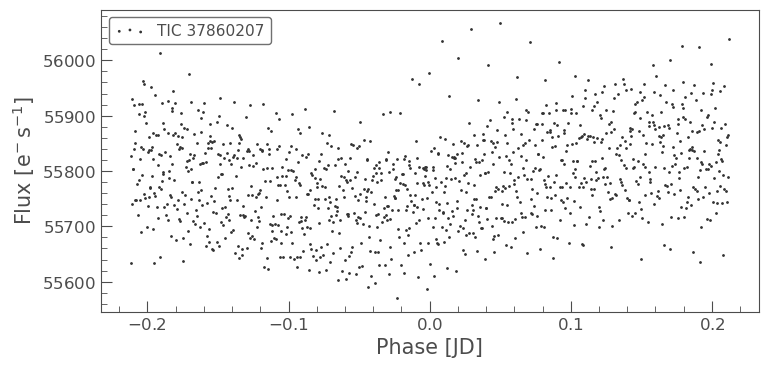

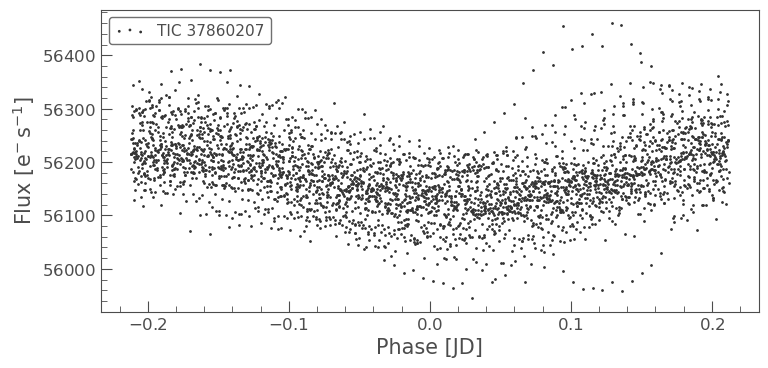

In [91]:
pg1.show_properties()

p1 = pg1.period_at_max_power
p2 = pg2.period_at_max_power   # find period at max power

lc_1.fold(p2).scatter()
lc_2.fold(p2).scatter()   # find out if period at max is the rotation period

print('p1 is too large, p2 seems more reliable.')



In [92]:
lc_1.meta

t1 = lc_1.time
f1 = lc_1.flux   # obtain time and flux values

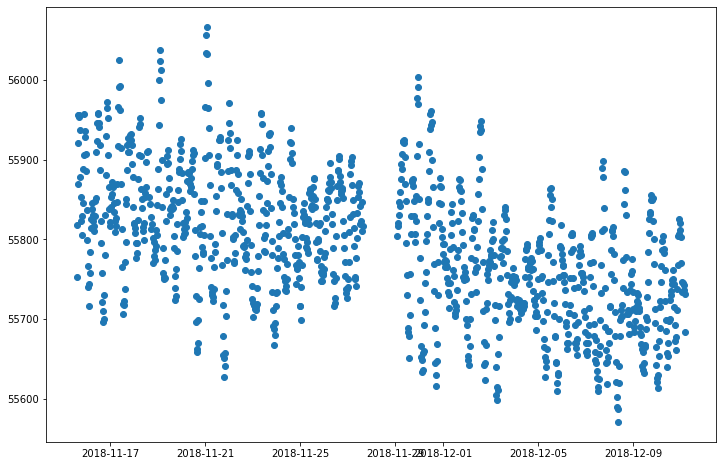

In [93]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot_date(t1.plot_date, f1)   # plot lightcurve from t1 and f1 directly

In [94]:
f1_c = correlate(f1, f1)   # try to auto-correlate

x = np.arange(0,len(f1_c),1)   # mock array as x axis for correlation function

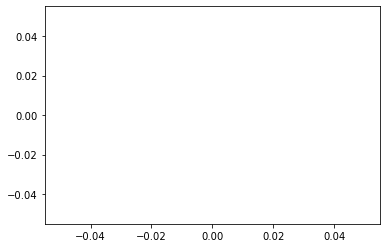

In [95]:
plt.plot(x, f1_c)   # does seem to show any result

In [96]:
t2 = lc_2.time
f2 = lc_2.flux   # check if same happens to the second lightcurve

In [97]:
f2   # inspect f2

<MaskedQuantity [      ———,       ———, 56215.973, ...,       ———,
                       ———,       ———] electron / s>

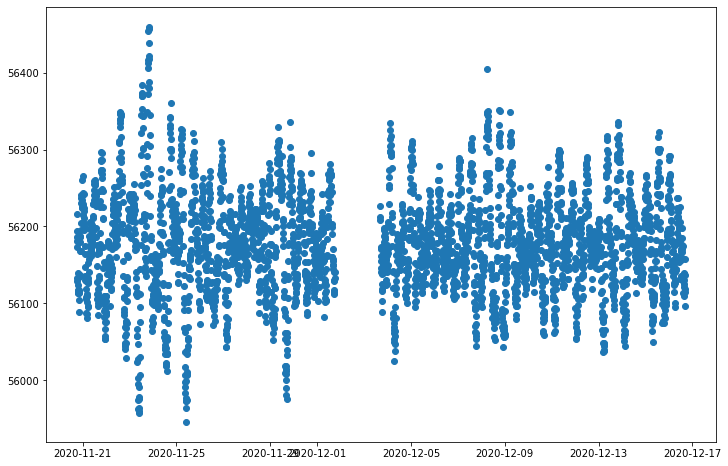

In [98]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot_date(t2.plot_date, f2)   # plot lightcurve directly from t2 and f2

In [99]:
f2_c = correlate(f2, f2)   # find auto-correlation of f2

/Users/yuzezhang/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/_signaltools.py:240: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


In [100]:
f2_c   # inspect correlation function

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [101]:
x = np.arange(0,len(f2_c),1)   # mock array for f2 correltion function

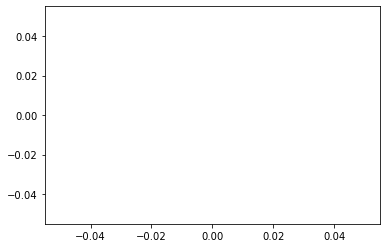

In [102]:
plt.plot(x, f2_c)   # try to plot correlation function

/Users/yuzezhang/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/_signaltools.py:240: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


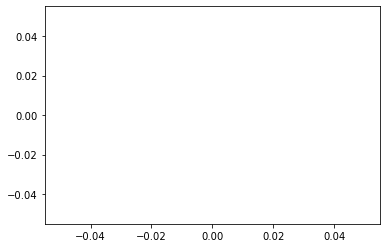

In [103]:
ex = f2[-1]
f2_m = f2[f2!=ex]
f2_cm = correlate(f2_m, f2_m)   # try to get rid of nan values in f2 and auto-correlate

x = np.arange(0,len(f2_cm),1)
plt.plot(x, f2_cm)   # plot correlation function

### source 2

In [104]:
sr = lk.search_lightcurve(Coord[1], author="TESS-SPOC")   # check second source on the list

lc_collection = sr.download_all()   # download lightcurve



In [105]:
lc_collection

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 9805084" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 9805084" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [106]:
lc_1 = lc_collection[0]
lc_2 = lc_collection[1]   # separate two lightcurve

t1 = lc_1.time
f1 = lc_1.flux   # obtain time and flux values

In [107]:
f1

<MaskedQuantity [76190.836, 76106.24 , 76082.26 , ...,       ———,
                       ———,       ———] electron / s>

In [108]:
t2 = lc_2.time
f2 = lc_2.flux   # obtain time and flux values

In [149]:
f2
t2.format = 'jd'
t2

<Time object: scale='tdb' format='jd' value=[2459144.52964398 2459144.53658861 2459144.54353325 ... 2459169.93244318
 2459169.93938747 2459169.94633176]>

In [150]:
F2 = []
T2 = []
for i in range(len(f2)):
    f2_v = float(f2[i].value)
    F2.append(f2_v)
    t2_v = float(t2[i].value)
    T2.append(t2_v)
    
F2 = np.array(F2)
T2 = np.array(T2)

T2 = T2[F2>0]
F2 = F2[F2>0]

In [151]:
Diff_T = T2[1:]-T2[:-1]
max_diff = np.amax(Diff_T)
idx = int(np.where(Diff_T==max_diff)[0])

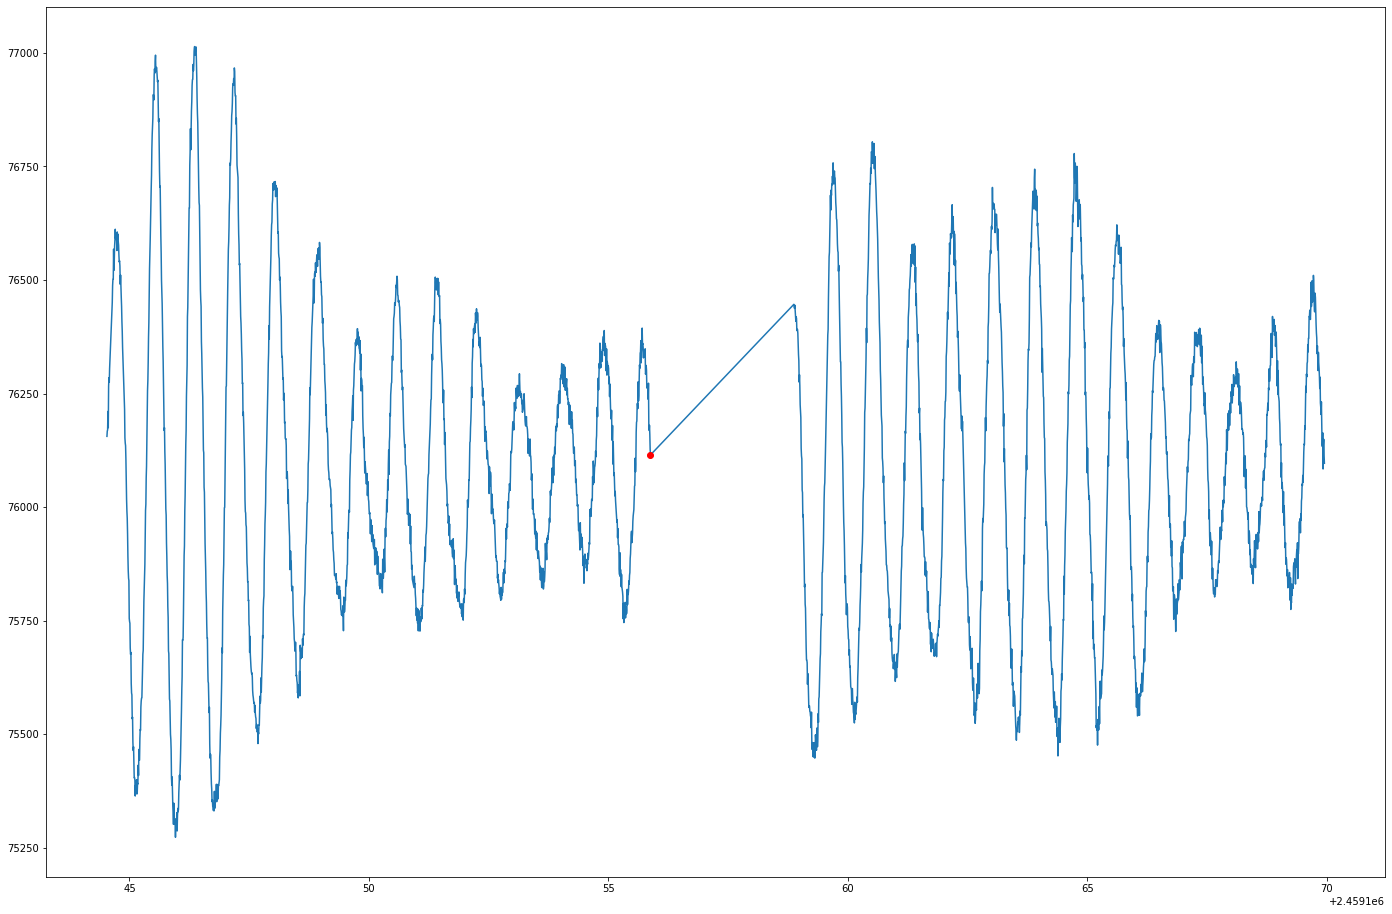

In [152]:
fig, ax = plt.subplots(figsize=(24,16))
plt.plot(T2, F2)
plt.plot(T2[idx], F2[idx], 'ro')

In [153]:
T_sec1 = T2[:idx+1]
F_sec1 = F2[:idx+1]

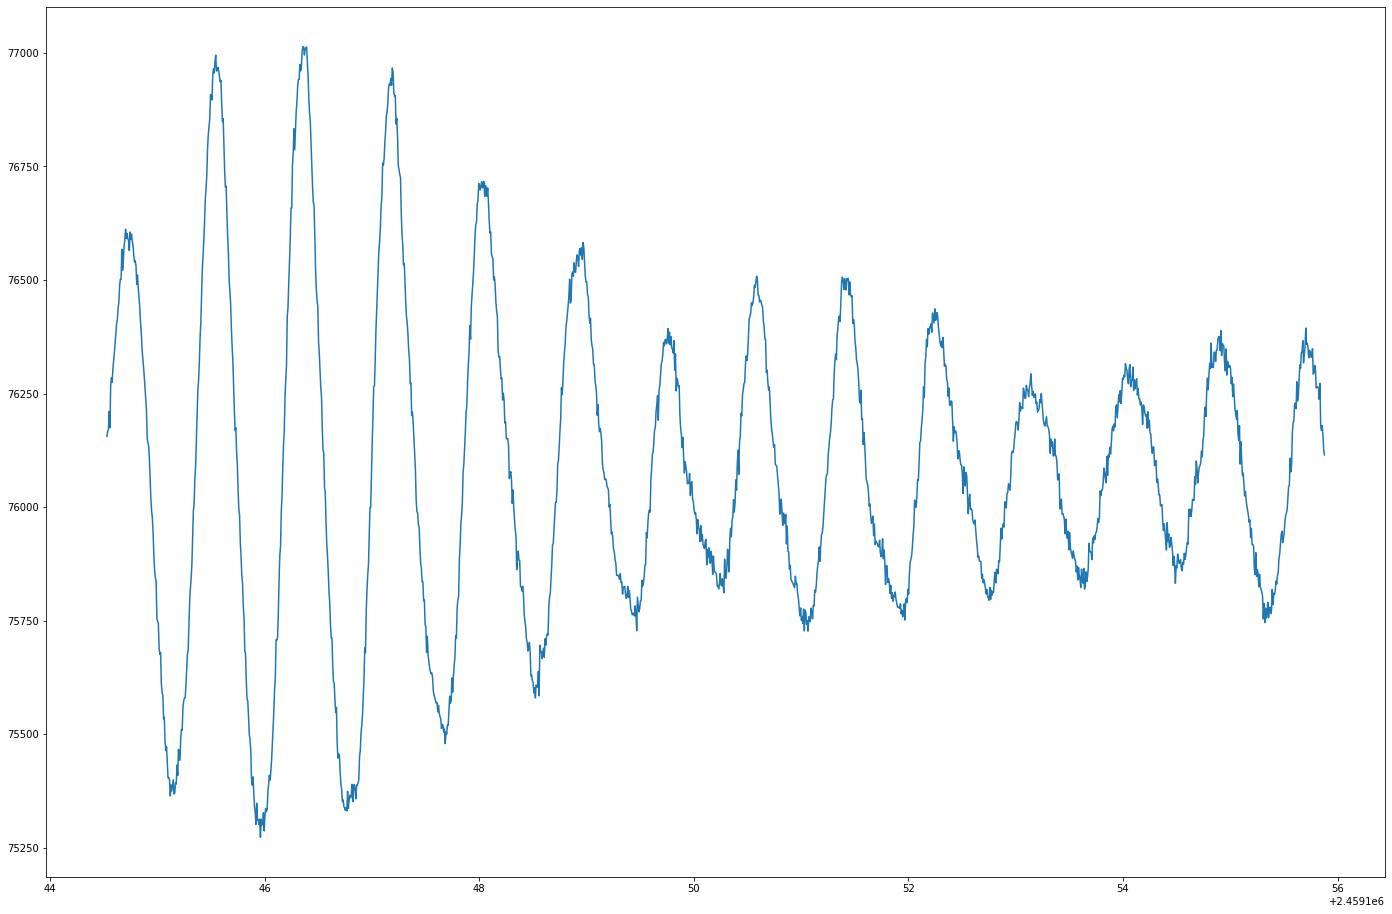

In [154]:
fig, ax = plt.subplots(figsize=(24,16))
plt.plot(T_sec1, F_sec1)

0.8263986711390316

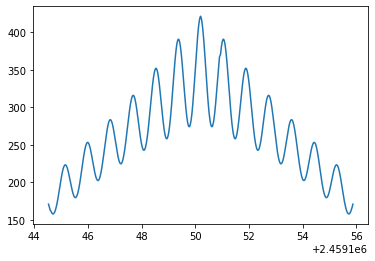

In [168]:
f_max = np.amax(F_sec1)
f_min = np.amin(F_sec1)
range_f = f_max-f_min
f_norm = (F_sec1-f_min)/range_f

y_c = np.sin(np.arange(0,len(f_norm),1))

F_sec1_c = correlate(f_norm, f_norm, mode='same')

cx = np.arange(0,len(F_sec1_c),1)
len(cx)==len(F_sec1_c)

plt.plot(T_sec1, F_sec1_c)

near_max = np.amax(F_sec1_c[:int(len(F_sec1_c)/2-20)])
idx_nmax = int(np.where(F_sec1_c==near_max)[0][0])
t_nmax = T_sec1[idx_nmax]

max_ = np.amax(F_sec1_c)
idx_max = int(np.where(F_sec1_c==max_)[0])
t_max = T_sec1[idx_max]

t_max - t_nmax

In [160]:
np.where(F_sec1_c==near_max)[0][0]

811

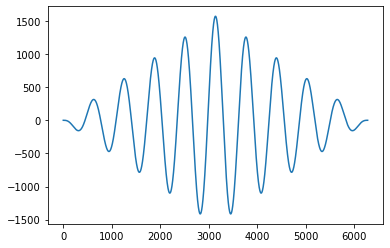

In [132]:
xc = np.arange(0,10*np.pi,0.01)
yc = np.sin(xc)

cc = correlate(yc, yc)
xcc = np.arange(0, len(cc), 1)

plt.plot(xcc, cc)

In [114]:
a = [1,2,3]
b = [2,3,4]

c = correlate(a, b)

In [115]:
c

array([ 4, 11, 20, 13,  6])

In [134]:
help(lc_1)

Help on TessLightCurve in module lightkurve.lightcurve object:

class TessLightCurve(LightCurve)
 |  TessLightCurve(data=None, *args, time=None, flux=None, flux_err=None, **kwargs)
 |  
 |  Subclass of :class:`LightCurve <lightkurve.lightcurve.LightCurve>`
 |  to represent data from NASA's TESS mission.
 |  
 |  Method resolution order:
 |      TessLightCurve
 |      LightCurve
 |      astropy.timeseries.sampled.TimeSeries
 |      astropy.timeseries.core.BaseTimeSeries
 |      astropy.table.table.QTable
 |      astropy.table.table.Table
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  to_fits(self, path=None, overwrite=False, flux_column_name='FLUX', aperture_mask=None, **extra_data)
 |      Writes the KeplerLightCurve to a FITS file.
 |      
 |      Parameters
 |      ----------
 |      path : string, default None
 |          File path, if `None` returns an astropy.io.fits.HDUList object.
 |      overwrite : bool
 |          Whether or not to overwrite the file
 |     

In [167]:
lc_1.quality_bitmask

'none'

In [138]:
lc_1.flux

<MaskedQuantity [76190.836, 76106.24 , 76082.26 , ...,       ———,
                       ———,       ———] electron / s>

In [280]:
x = np.linspace(0,np.pi*4,1000)
a_sin = np.sin(x)
b_sin = np.sin(x)

c = correlate(a_sin, b_sin)

In [281]:
c

array([ 0.00000000e+00, -6.16174563e-18, -1.58221627e-04, ...,
       -1.58221627e-04, -6.16174563e-18,  0.00000000e+00])